## Diffusion lengthscale

Toy model of 1-D diffusion of a linear concentration profile through two layers with different diffusivities. 

We discretize the 1-D diffusion equation 

$$\frac{\partial C}{\partial t} =  \frac{\partial}{\partial z}\Big(\frac{\kappa\partial C}{\partial z}\Big)$$

using using forward differences for time and the spatial stencil

 o----x----o----x----o    

i-1---ki---i---ki+1--i+1   

Ci-1-------Ci--------Ci+1   


as

$$\frac{C_i^{n+1}-C_i^{n}}{\Delta t}= \frac{\kappa_i(C_{i}^n-C_{i-1}^n)-\kappa_{i+1}(C_{i+1}^n-C_i^n)}{\Delta z^2}$$

using forward differences for time. Note that when $\kappa_i = \kappa_{i+1}$, we recover the usual central differences scheme for the second derivative:

$$\frac{C_i^{n+1}-C_i^{n}}{\Delta t}= \frac{\kappa(C_{i+1}^n-2C_{i}^n+C_{i-1}^n)}{\Delta z^2}$$

So, we calculate the concentration at time step n+1 as

$$C_i^{n+1}=\frac{\Delta t}{\Delta z^2}(\kappa_i(C_{i}^n-C_{i-1}^n)-\kappa_{i+1}(C_{i+1}^n-C_i^n)) + C_i^{n}$$.


In [38]:
import cmocean as cmo
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [39]:
# Plots appearance
sns.set_context('talk')
sns.set_style('whitegrid')

In [40]:
def timestepping(IC, kappa, dt, dz, nt):
    '''Iterate for nt timesteps the solution to the diffusion equation
    INPUT
    IC: vector with the initial condition (1D numpy array)
    kappa: 1D numpy array, same size as u
    dt: timestep size (scalar)
    dz: depth of cells (scalar)
    nt: number of timesteps
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    un = np.ones(nz) #our placeholder array, un, to advance the solution in time
    u = np.ones(nz) #our placeholder array, un, to advance the solution in time
    u = IC.copy()
    
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nz - 1):
            u[i] = un[i] + (kappa[i] * dt / dz**2 * (un[i+1] - 2 * un[i] + un[i-1]))
    return u

def timesteppingKv(IC, kappa, dt, dz, nt):
    '''Iterate for nt timesteps the solution to the diffusion equation with variable Kv
    INPUT
    IC: vector with the initial condition (1D numpy array)
    kappa: 1D numpy array, same size as u
    dt: timestep size (scalar)
    dz: depth of cells (scalar)
    nt: number of timesteps
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    un = np.ones(nz) 
    u = np.ones(nz) 
    u = IC.copy()
    
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nz - 1):
            u[i] = un[i] + dt * (kappa[i]*(un[i-1]-un[i])/dz**2 - kappa[i+1]*(un[i]-un[i+1])/dz**2)
    return u

def smoothHS(nx, xi, epsilon, dx, k1, k2):
    '''Build smooth Heaviside function, of width 2*epsilon centred at index xi
    Check:
    xi < nx ''' 
    
    hs = np.zeros(nx)
    
    hs[:xi-epsilon+1] = k1
    
    for ii in range(2*epsilon):
        hs[xi+ii-epsilon] = k1+(0.5 + (ii-epsilon)/(2*epsilon) + 
                             (np.sin(np.pi*(ii-epsilon)/epsilon))/(2*np.pi))*k2
    
    hs[xi+epsilon-1:] = k2+k1
    
    return hs
     
    
def plotICs(IniC,kappa,L,nz):
    '''Plots initial conditions and diffusivity profile, creates figure inside and returns fig and ax handles'''
    fig,(ax1,ax2) = plt.subplots(1,2,sharey = True,figsize=(8,3))

    ax1.plot(IniC, -np.linspace(0, L, nz))
    ax1.set_xlabel('Concentration ($\mu M$)')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('Initial concentration')

    ax2.plot(kappa,-np.linspace(0, L, nz))
    ax2.set_xlabel('$\kappa$ (m$^2$s$^{-1}$)')
    ax2.set_title('Diffusivity profile')
    
    return(fig,ax1,ax2)

def plotCpaper(ax, C, L, nz, colour):
    '''Plots concentration over an existing ax and returns ax handle and line handle'''
    line, = ax.plot(C, -np.linspace(0, L, nz), color=colour);
    ax.set_xlabel('Concentration ($\mu M$)', labelpad=0.5)
    ax.set_ylabel('Depth (m)',labelpad=-0.5)
    return (line)

def plotC(ax, C, L, nz):
    '''Plots concentration over an existing ax and returns ax handle and line handle'''
    line, = ax.plot(C, -np.linspace(0, L, nz));
    ax.set_xlabel('Concentration ($\mu M$)', labelpad=0.5)
    ax.set_ylabel('Depth (m)',labelpad=-0.5)
    return (line)

def plotdCdz(ax, C, L, nz):
    '''Plots vertical concentration gradient over an existing ax and returns ax handle and line handle'''
    z = -np.linspace(0, L, nz)
    dCdz = (C[:-1]-C[1:])/(z[:-1]-z[1:])
    line, = ax.plot(dCdz, z[:-1]);
    ax.set_xlabel('$\partial_zC$ ($\mu M m^{-1}$)', labelpad=0.5)
    ax.set_ylabel('Depth (m)',labelpad=-0.5)
    return (line)

In [41]:
# INITIALIZATION 

# Space
nz = 100           # number of points in z
L = 100            # total depth (m)
dz = L / (nz - 1)  # vertical spacing (m)

# Time
dt = 60  # time step (s)
to_day = dt/(3600*24)

# Diffusivity
kappa_bg = 1E-5              # background diffusivity
kappa_can = 1E-3             # canyon diffusivity
kappa = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa[int(nz/2):] = kappa_can

#epsilon = 10
#kappa = smoothHS(nz, 50, epsilon, dz, kappa_bg, kappa_can)

# Talk to me
print('The time step is %1.1f seconds' %dt)
print('The vertical resolution is %1.3f meters' %dz)

The time step is 60.0 seconds
The vertical resolution is 1.010 meters


## Hat profile

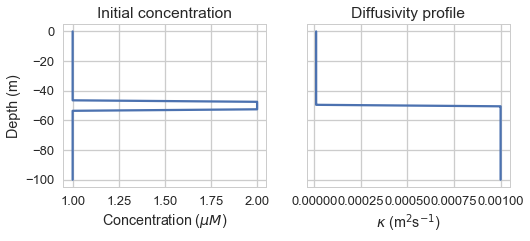

In [42]:
# Initial conditon
IC = np.ones(nz)     
IC[int(nz/2)-3:int(nz/2)+3] = 2  # It's a hat 

fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

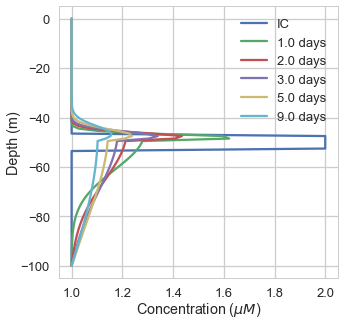

In [43]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(5,5))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]


for time in times:
    conc = timesteppingKv(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),
                    '%1.1f days' %(times[1]*to_day),
                    '%1.1f days' %(times[2]*to_day),
                    '%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day))) 

Now, let's compare to the diffusion discretization when we don't take into account the derivative of $\kappa$:

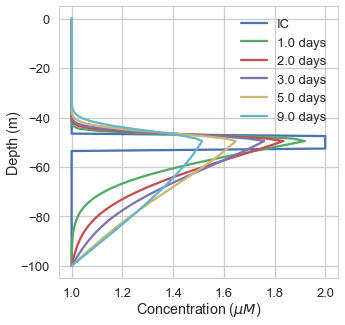

In [44]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(5,5))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc = timestepping(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),
                    '%1.1f days' %(times[1]*to_day),
                    '%1.1f days' %(times[2]*to_day),
                    '%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day))) 

## Parabolic profile

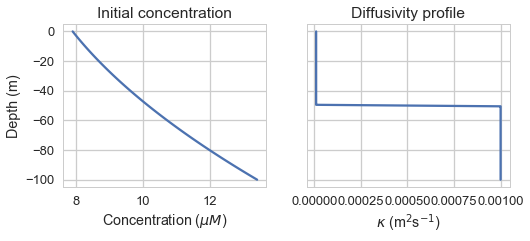

In [45]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.0002*(ii*dz)**2+0.035*ii*dz+7.9

fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

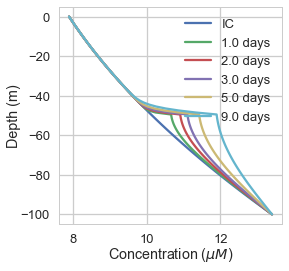

In [46]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(4,4))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc = timesteppingKv(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),'%1.1f days' %(times[1]*to_day),
                     '%1.1f days' %(times[2]*to_day),'%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day))) 

## Linear profile

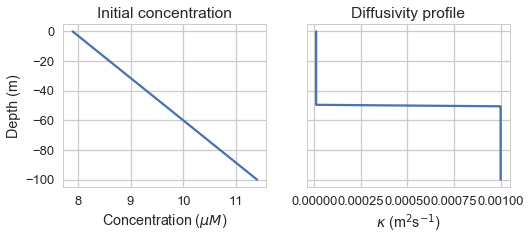

In [47]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9
    
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

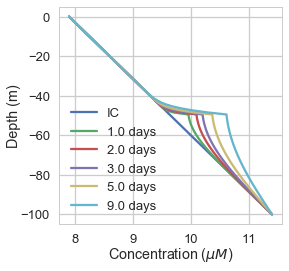

In [48]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(4,4))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc = timesteppingKv(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),'%1.1f days' %(times[1]*to_day),
                     '%1.1f days' %(times[2]*to_day),'%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day))) 

## Smoothed $\kappa$ profile

What happens if we smooth out the diffusivity profile from a step (Heaviside function) to a smoothed Heaviside function? (The concentration will look smoother but how does it change the tracer transport?)

Smoothed Heaviside function:

$HS(z) = \begin{cases}
\kappa_{bg} &\mbox{if } z<\frac{L}{2}-\epsilon \\
\kappa_{bg}+ \kappa_{can}(0.5 + \frac{z-\epsilon}{2\epsilon} + \frac{1}{2\pi}\sin{\frac{\pi(z-\epsilon)}{\epsilon}}) & \mbox{if } \frac{L}{2}-\epsilon < z < \frac{L}{2}+\epsilon \\
\kappa_{can} & \mbox{if }  \frac{L}{2}+\epsilon < z
 \end{cases} $

We will compare several values of $\epsilon$.

In [49]:
# Smoothed Heaviside function for diffusivity
e01 = 1
kappa_e01 = smoothHS(nz, int(nz/2), e01, dz, kappa_bg, kappa_can)

e05 = 5
kappa_e05 = smoothHS(nz, int(nz/2), e05, dz, kappa_bg, kappa_can)

e10 = 10
kappa_e10 = smoothHS(nz, int(nz/2), e10, dz, kappa_bg, kappa_can)

e25 = 25
kappa_e25 = smoothHS(nz, int(nz/2), e25, dz, kappa_bg, kappa_can)

Text(0.0009,10,'$\\epsilon=25$ m')

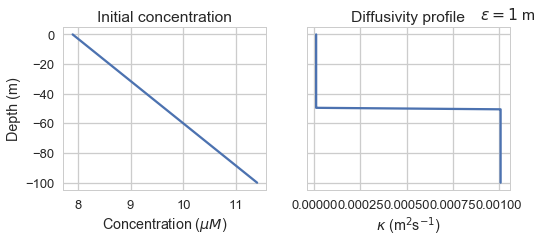

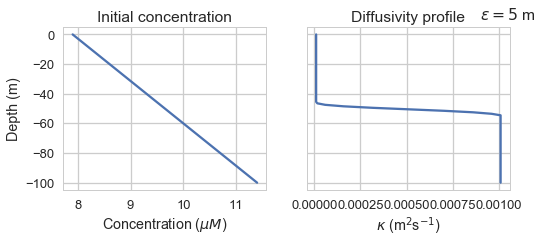

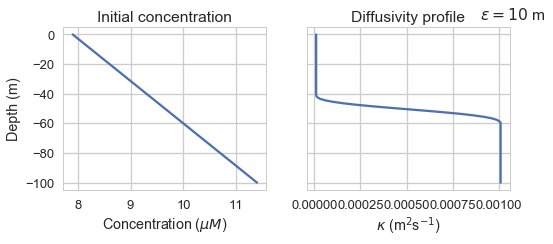

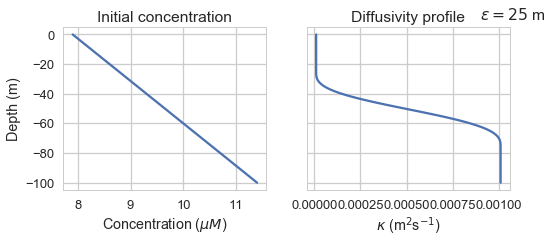

In [50]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

fig, ax1, ax2 = plotICs(IC,kappa_e01,L,nz)
ax2.text(0.0009,10,'$\epsilon=1$ m')
fig, ax1, ax2 = plotICs(IC,kappa_e05,L,nz)
ax2.text(0.0009,10,'$\epsilon=5$ m')
fig, ax1, ax2 = plotICs(IC,kappa_e10,L,nz)
ax2.text(0.0009,10,'$\epsilon=10$ m')
fig, ax1, ax2 = plotICs(IC,kappa_e25,L,nz)
ax2.text(0.0009,10,'$\epsilon=25$ m')

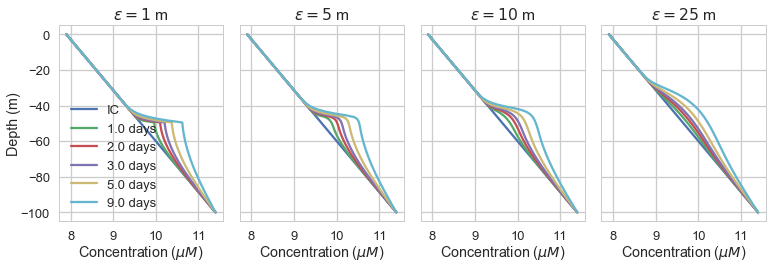

In [51]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,4, figsize=(11,4), sharey = True)

for axii in ax: 
    l1 = plotC(axii, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc01 = timesteppingKv(IC, kappa_e01, dt, dz, time)
    conc05 = timesteppingKv(IC, kappa_e05, dt, dz, time)
    conc10 = timesteppingKv(IC, kappa_e10, dt, dz, time)
    conc25 = timesteppingKv(IC, kappa_e25, dt, dz, time)
    l2 = plotC(ax[0], conc01, L, nz)
    l3 = plotC(ax[1], conc05, L, nz)
    l4 = plotC(ax[2], conc10, L, nz)
    l5 = plotC(ax[3], conc25, L, nz)
    lines.append(l2)

ax[0].legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),'%1.1f days' %(times[1]*to_day),
                     '%1.1f days' %(times[2]*to_day),'%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day)), loc=0) 

ax[0].set_title('$\epsilon = 1$ m')
ax[1].set_title('$\epsilon = 5$ m')
ax[2].set_title('$\epsilon = 10$ m')
ax[3].set_title('$\epsilon = 25$ m')

ax[1].set_ylabel('')
ax[3].set_ylabel('')
ax[2].set_ylabel('')

plt.tight_layout()
plt.savefig('Cprofiles_epsilon.eps',format='eps',bbox_inches='tight')


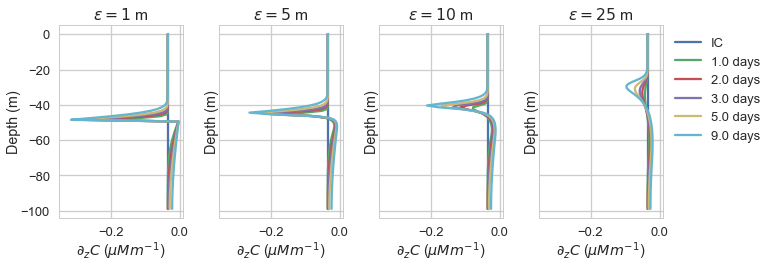

In [52]:
# PLOT RESULTING Derivative
fig, ax = plt.subplots(1,4, figsize=(11,4), sharey = True)

for axii in ax: 
    l1 = plotdCdz(axii, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc01 = timesteppingKv(IC, kappa_e01, dt, dz, time)
    conc05 = timesteppingKv(IC, kappa_e05, dt, dz, time)
    conc10 = timesteppingKv(IC, kappa_e10, dt, dz, time)
    conc25 = timesteppingKv(IC, kappa_e25, dt, dz, time)
    l2 = plotdCdz(ax[0], conc01, L, nz)
    l3 = plotdCdz(ax[1], conc05, L, nz)
    l4 = plotdCdz(ax[2], conc10, L, nz)
    l5 = plotdCdz(ax[3], conc25, L, nz)
    lines.append(l2)

    
ax[3].legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),'%1.1f days' %(times[1]*to_day),
                     '%1.1f days' %(times[2]*to_day),'%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day)), bbox_to_anchor=(1,1)) 

ax[0].set_title('$\epsilon = 1$ m')
ax[1].set_title('$\epsilon = 5$ m')
ax[2].set_title('$\epsilon = 10$ m')
ax[3].set_title('$\epsilon = 25$ m')
ax[0].set_xlim(-0.35,0.01)
ax[1].set_xlim(-0.35,0.01)
ax[2].set_xlim(-0.35,0.01)
ax[3].set_xlim(-0.35,0.01)
plt.tight_layout()
#plt.savefig('dCdzprofiles_Kvs.eps',format='eps',bbox_inches='tight')


## Concentration contours

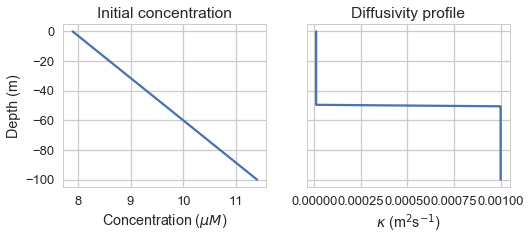

In [53]:
sns.set_style('whitegrid')

# Set diffusivity profile
kappa = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa[int(nz/2):] = kappa_can

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D[:,tt] = timesteppingKv(IC, kappa, dt, dz, 288)
    IC = conc_2D[:,tt]

(100, 45)


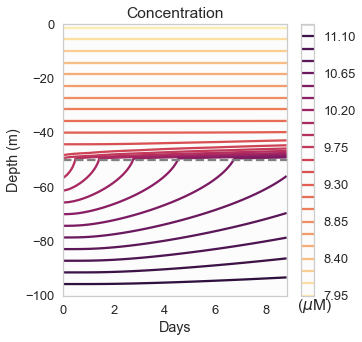

In [54]:
sns.set_style('white',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot density contours
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey = True)
ax.axhline(-int(nz/2), linestyle='--', color='0.5')

CS = ax.contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D, 25, cmap=cmo.cm.matter)
CB = plt.colorbar(CS, ax=ax)
ax.text(9.2,-105,'($\mu$M)')
ax.set_title('Concentration')
ax.set_xlabel('Days')
ax.set_ylabel('Depth (m)')

print(np.shape(conc_2D))

### Larger $\epsilon$ (smoother Kv profile)

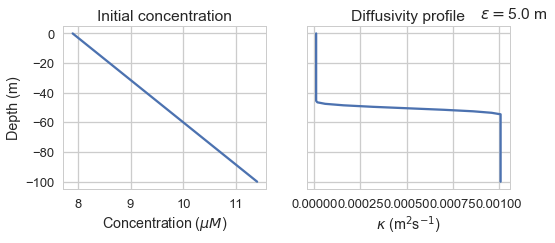

In [55]:
sns.set_style('whitegrid')

# Set diffusivity profile
epsilon = 5
kappa = smoothHS(nz, int(nz/2), epsilon, dz, kappa_bg, kappa_can)

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)
ax2.text(0.0009,10,'$\epsilon=$%1.1f m' %epsilon)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D_e5 = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D_e5[:,tt] = timesteppingKv(IC, kappa, dt, dz, 288)
    IC = conc_2D_e5[:,tt]

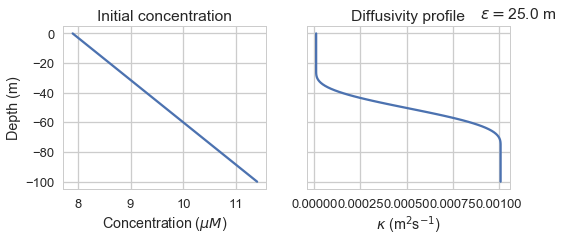

In [56]:
sns.set_style('whitegrid')

# Set diffusivity profile
epsilon = 25
kappa = smoothHS(nz, int(nz/2), epsilon, dz, kappa_bg, kappa_can)

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)
ax2.text(0.0009,10,'$\epsilon=$%1.1f m' %epsilon)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D_e25 = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D_e25[:,tt] = timesteppingKv(IC, kappa, dt, dz, 288)
    IC = conc_2D_e25[:,tt]

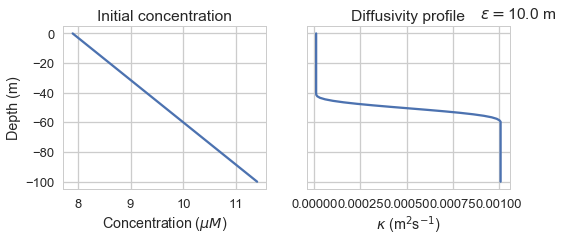

In [57]:
sns.set_style('whitegrid')

# Set diffusivity profile
epsilon = 10
kappa = smoothHS(nz, int(nz/2), epsilon, dz, kappa_bg, kappa_can)

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)
ax2.text(0.0009,10,'$\epsilon=$%1.1f m' %epsilon)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D_e10 = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D_e10[:,tt] = timesteppingKv(IC, kappa, dt, dz, 288)
    IC = conc_2D_e10[:,tt]

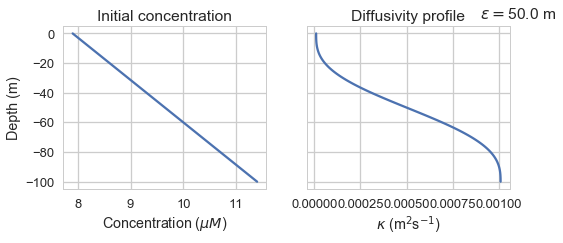

In [58]:
sns.set_style('whitegrid')

# Set diffusivity profile
epsilon = 50
kappa = smoothHS(nz, int(nz/2), epsilon, dz, kappa_bg, kappa_can)

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)
ax2.text(0.0009,10,'$\epsilon=$%1.1f m' %epsilon)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D_e50 = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D_e50[:,tt] = timesteppingKv(IC, kappa, dt, dz, 288)
    IC = conc_2D_e50[:,tt]

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


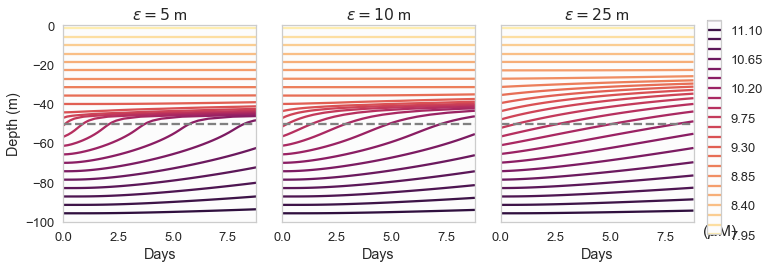

In [59]:
sns.set_style('white',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot density contours
fig, ax = plt.subplots(1,3, figsize=(10,4), sharey = True)
ax[0].axhline(-int(nz/2), linestyle='--', color='0.5')
ax[1].axhline(-int(nz/2), linestyle='--', color='0.5')
ax[2].axhline(-int(nz/2), linestyle='--', color='0.5')

CS = ax[0].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_e5,25, 
                   cmap=cmo.cm.matter)
ax[0].set_title('$\epsilon=5$ m')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Depth (m)')

CS = ax[1].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_e10,25, 
                   cmap=cmo.cm.matter)
ax[1].set_title('$\epsilon=10$ m')
ax[1].set_xlabel('Days')

CS = ax[2].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_e25,25, 
                   cmap=cmo.cm.matter)

cb = fig.add_axes([0.995, 0.15, 0.02, 0.745]) 
CB = plt.colorbar(CS, cax=cb)
ax[2].text(9.2,-107,'($\mu$M)')
ax[2].set_title('$\epsilon=25$ m')
ax[2].set_xlabel('Days')
plt.tight_layout()

plt.savefig('Ccontours_epsilon.eps',format='eps',bbox_inches='tight')


Is the integral $\int_H^0Cdz$ constant for different epsilons?

In [60]:
# Integate along water column

int_e05 = np.sum(conc_2D_e5[:,int(time/288)]*dz)
int_e10 = np.sum(conc_2D_e10[:,int(time/288)]*dz)
int_e25 = np.sum(conc_2D_e25[:,int(time/288)]*dz)
int_e50 = np.sum(conc_2D_e50[:,int(time/288)]*dz)

print(int_e05, int_e10, int_e25, int_e50)

998.596376213 998.99484804 999.269227266 998.510791263


## Smaller $\kappa_{can}$

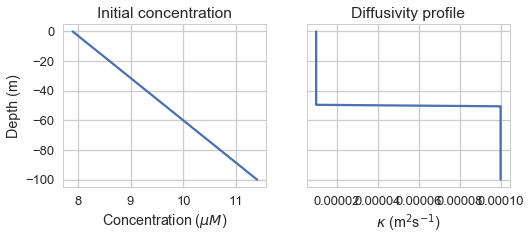

In [61]:
sns.set_style('whitegrid')

# Set diffusivity profile
kappa_sm = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa_sm[int(nz/2):] = 1E-4

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa_sm,L,nz)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D_sm = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D_sm[:,tt] = timesteppingKv(IC, kappa_sm, dt, dz, 288)
    IC = conc_2D_sm[:,tt]

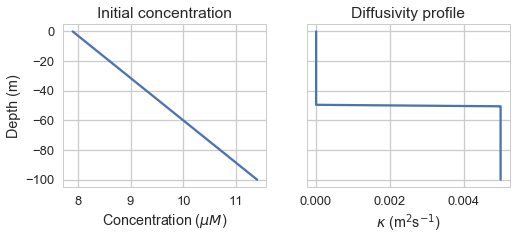

In [62]:
sns.set_style('whitegrid')

# Set diffusivity profile
kappa_big = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa_big[int(nz/2):] = 5E-3

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa_big,L,nz)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D_bg = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D_bg[:,tt] = timesteppingKv(IC, kappa_big, dt, dz, 288)
    IC = conc_2D_bg[:,tt]

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


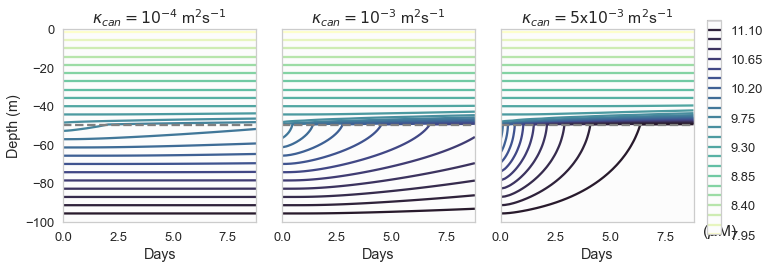

In [63]:
sns.set_style('white',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot density contours
fig, ax = plt.subplots(1,3, figsize=(10,4), sharey = True)
ax[0].axhline(-int(nz/2), linestyle='--', color='0.5')
ax[1].axhline(-int(nz/2), linestyle='--', color='0.5')
ax[2].axhline(-int(nz/2), linestyle='--', color='0.5')

CS = ax[0].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_sm,25, cmap=cmo.cm.deep)
ax[0].set_title('$\kappa_{can}=10^{-4}$ m$^2$s$^{-1}$')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Depth (m)')

CS = ax[1].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D,25, cmap=cmo.cm.deep)
ax[1].set_title('$\kappa_{can}=10^{-3}$ m$^2$s$^{-1}$')
ax[1].set_xlabel('Days')

CS = ax[2].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_bg,25, cmap=cmo.cm.deep)

cb = fig.add_axes([0.995, 0.15, 0.02, 0.745]) 
CB = plt.colorbar(CS, cax=cb)
ax[2].text(9.2,-107,'($\mu$M)')
ax[2].set_title('$\kappa_{can}=5$x$10^{-3}$ m$^2$s$^{-1}$')
ax[2].set_xlabel('Days')
plt.tight_layout()

plt.savefig('Ccontours_Kvs.eps',format='eps',bbox_inches='tight')



/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


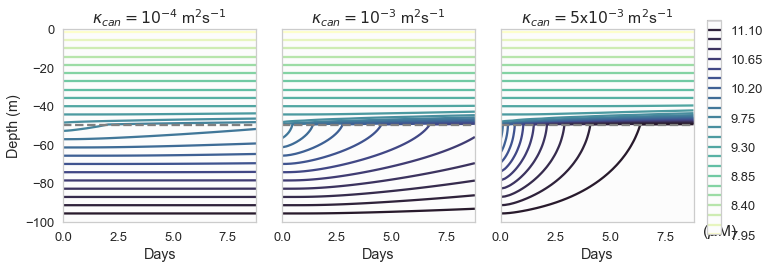

In [64]:
sns.set_style('white',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot density contours
fig, ax = plt.subplots(1,3, figsize=(10,4), sharey = True)
ax[0].axhline(-int(nz/2), linestyle='--', color='0.5')
ax[1].axhline(-int(nz/2), linestyle='--', color='0.5')
ax[2].axhline(-int(nz/2), linestyle='--', color='0.5')

CS = ax[0].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_sm,25, cmap=cmo.cm.deep)
ax[0].set_title('$\kappa_{can}=10^{-4}$ m$^2$s$^{-1}$')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Depth (m)')

CS = ax[1].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D,25, cmap=cmo.cm.deep)
ax[1].set_title('$\kappa_{can}=10^{-3}$ m$^2$s$^{-1}$')
ax[1].set_xlabel('Days')

CS = ax[2].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_bg,25, cmap=cmo.cm.deep)

cb = fig.add_axes([0.995, 0.15, 0.02, 0.745]) 
CB = plt.colorbar(CS, cax=cb)
ax[2].text(9.2,-107,'($\mu$M)')
ax[2].set_title('$\kappa_{can}=5$x$10^{-3}$ m$^2$s$^{-1}$')
ax[2].set_xlabel('Days')
plt.tight_layout()

plt.savefig('Ccontours_Kvs.eps',format='eps',bbox_inches='tight')



4.0
14.0
24.0
34.0
44.0


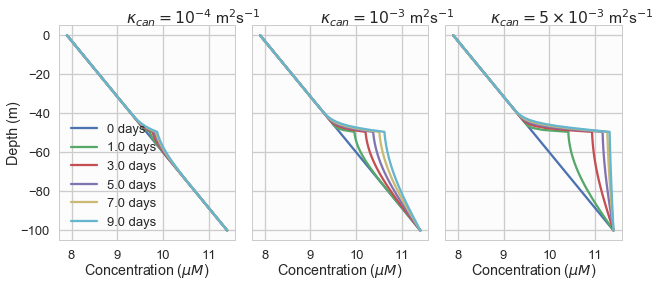

In [65]:
# PLOT RESULTING CONCENTRATION
sns.set_style('whitegrid',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"} )

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

fig, ax = plt.subplots(1,3, figsize=(9,4), sharey = True)
l1 = plotC(ax[0], IC, L, nz)
l1 = plotC(ax[1], IC, L, nz)
l1 = plotC(ax[2], IC, L, nz)

lines = [l1]

for time in times[4::10]:
    l2 = plotC(ax[0], conc_2D_sm[:,int(time/288)], L, nz)
    lines.append(l2)
    print(((time)/288)) 
    l2 = plotC(ax[1], conc_2D[:,int(time/288)], L, nz)
    l2 = plotC(ax[2], conc_2D_bg[:,int(time/288)], L, nz)
    
ax[0].legend((lines), ('0 days' , '%1.1f days' %(times[4]*to_day+0.2),
                       '%1.1f days' %(times[14]*to_day+0.2),
                       '%1.1f days' %(times[24]*to_day+0.2),
                       '%1.1f days'%(times[34]*to_day+0.2),
                       '%1.1f days'%(times[44]*to_day+0.2)),loc=3) 
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].text(9.2, 6, r'$\kappa_{can} = 10^{-4}$ m$^2$s$^{-1}$')
ax[1].text(9.2, 6,r'$\kappa_{can} = 10^{-3}$ m$^2$s$^{-1}$')
ax[2].text(8.7, 6,r'$\kappa_{can} = 5 \times 10^{-3}$ m$^2$s$^{-1}$')

plt.tight_layout()
plt.savefig('Cprofiles_Kvs.eps',format='eps',bbox_inches='tight')


In [66]:
# Integate along water column

int_sm = np.sum(conc_2D_sm[:,int(time/288)]*dz)
int_0 = np.sum(conc_2D[:,int(time/288)]*dz)
int_bg = np.sum(conc_2D_bg[:,int(time/288)]*dz)

print(int_sm, int_0, int_bg)

977.196895378 997.844090641 1021.69962066


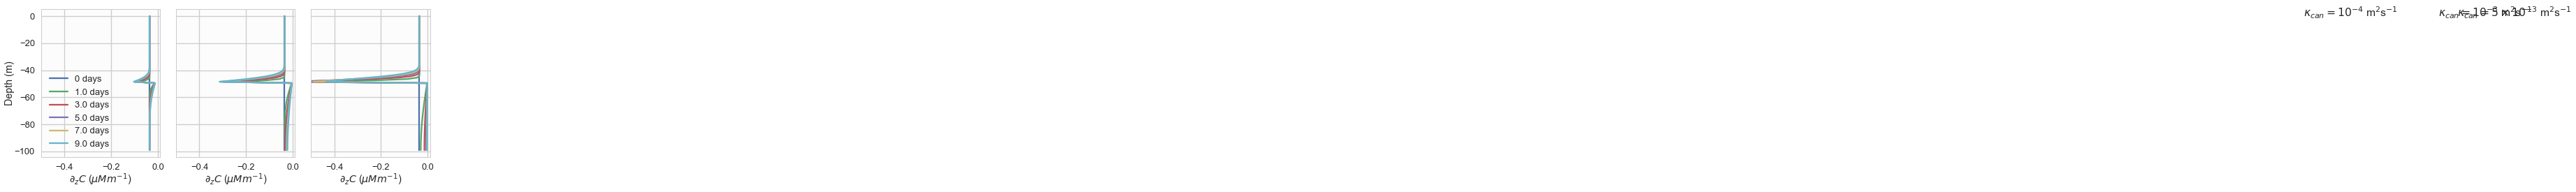

In [67]:
# PLOT RESULTING Derivative
sns.set_style('whitegrid',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"} )

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

fig, ax = plt.subplots(1,3, figsize=(9,4), sharey = True)
l1 = plotdCdz(ax[0], IC, L, nz)
l1 = plotdCdz(ax[1], IC, L, nz)
l1 = plotdCdz(ax[2], IC, L, nz)

lines = [l1]

for time in times[4::10]:
    l2 = plotdCdz(ax[0], conc_2D_sm[:,int(time/288)], L, nz)
    lines.append(l2)
    #print(((time)/288)) 
    l2 = plotdCdz(ax[1], conc_2D[:,int(time/288)], L, nz)
    l2 = plotdCdz(ax[2], conc_2D_bg[:,int(time/288)], L, nz)
    
ax[0].legend((lines), ('0 days' , '%1.1f days' %(times[4]*to_day+0.2),
                       '%1.1f days' %(times[14]*to_day+0.2),
                       '%1.1f days' %(times[24]*to_day+0.2),
                       '%1.1f days'%(times[34]*to_day+0.2),
                       '%1.1f days'%(times[44]*to_day+0.2)),loc=3) 
ax[1].set_ylabel('')
ax[2].set_ylabel('')

ax[0].text(9.2, -0.4, r'$\kappa_{can} = 10^{-4}$ m$^2$s$^{-1}$')
ax[1].text(9.2, -0.4, r'$\kappa_{can} = 10^{-3}$ m$^2$s$^{-1}$')
ax[2].text(8.7, -0.4, r'$\kappa_{can} = 5 \times 10^{-3}$ m$^2$s$^{-1}$')
ax[0].set_xlim(-0.5,0.01)
ax[1].set_xlim(-0.5,0.01)
ax[2].set_xlim(-0.5,0.01)
plt.tight_layout()
#plt.savefig('dCdzprofiles_Kvs.eps',format='eps',bbox_inches='tight')


 Kappa_can = 10^-2 exploded.

Text(0.5,1,'depth 52.0 m')

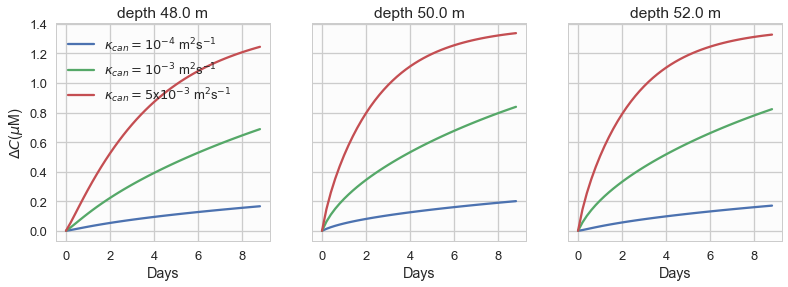

In [68]:
sns.set_style('whitegrid',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot concentration contours
fig, ax = plt.subplots(1,3, figsize=(13,4), sharey = True)

CS = ax[0].plot(np.array(times)*to_day,
                conc_2D_sm[int(nz/2)-2,:] - conc_2D_sm[int(nz/2)-2,0],
                label='$\kappa_{can}=10^{-4}$ m$^2$s$^{-1}$')
CS = ax[0].plot(np.array(times)*to_day,
                conc_2D[int(nz/2)-2,:] - conc_2D[int(nz/2)-2,0],
                label='$\kappa_{can}=10^{-3}$ m$^2$s$^{-1}$' )
CS = ax[0].plot(np.array(times)*to_day ,
                conc_2D_bg[int(nz/2)-2,:] - conc_2D_bg[int(nz/2)-2,0],
                label='$\kappa_{can}=5$x$10^{-3}$ m$^2$s$^{-1}$' )

ax[0].legend(loc=0)
ax[0].set_ylabel('$\Delta C$($\mu$M)')
ax[0].set_xlabel('Days')
ax[0].set_title('depth %1.1f m' %(int(nz/2)-2))

CS = ax[1].plot(np.array(times)*to_day ,
                conc_2D_sm[int(nz/2),:] - conc_2D_sm[int(nz/2),0],
                )
CS = ax[1].plot(np.array(times)*to_day ,
                conc_2D[int(nz/2),:] - conc_2D[int(nz/2),0],
                 )
CS = ax[1].plot(np.array(times)*to_day ,
                conc_2D_bg[int(nz/2),:] - conc_2D_bg[int(nz/2),0],
                )
ax[1].set_xlabel('Days')
ax[1].set_title('depth %1.1f m' %(int(nz/2)))

CS = ax[2].plot(np.array(times)*to_day ,
                conc_2D_sm[int(nz/2)+2,:] - conc_2D_sm[int(nz/2)+2,0],
               )
CS = ax[2].plot(np.array(times)*to_day ,
                conc_2D[int(nz/2)+2,:] - conc_2D[int(nz/2)+2,0],
                )
CS = ax[2].plot(np.array(times)*to_day ,
                conc_2D_bg[int(nz/2)+2,:] - conc_2D_bg[int(nz/2)+2,0],
                )
ax[2].set_xlabel('Days')
ax[2].set_title('depth %1.1f m' %(int(nz/2)+2))

Text(0.5,1,'depth 52.0 m')

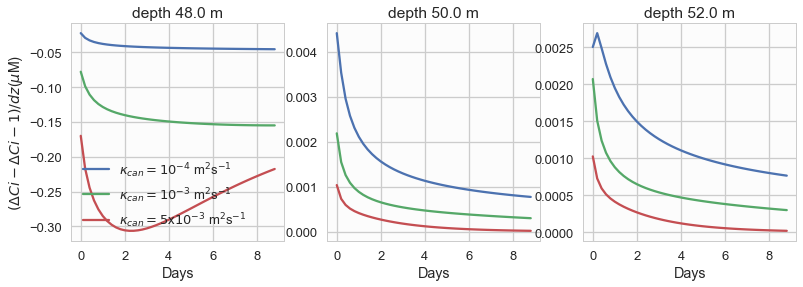

In [69]:
sns.set_style('whitegrid',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot concentration contours
fig, ax = plt.subplots(1,3, figsize=(13,4), sharey = False)

CS = ax[0].plot(np.array(times)*to_day,
                (conc_2D_sm[int(nz/2)-2,:] - 2*conc_2D_sm[int(nz/2)-1,:]+conc_2D_sm[int(nz/2),:])/(2*dz),
                label='$\kappa_{can}=10^{-4}$ m$^2$s$^{-1}$')
CS = ax[0].plot(np.array(times)*to_day,
                (conc_2D[int(nz/2)-2,:] - 2*conc_2D[int(nz/2)-1,:]+conc_2D[int(nz/2),:])/(2*dz),
                label='$\kappa_{can}=10^{-3}$ m$^2$s$^{-1}$' )
CS = ax[0].plot(np.array(times)*to_day ,
               (conc_2D_bg[int(nz/2)-2,:] - 2*conc_2D_bg[int(nz/2)-1,:]+conc_2D_bg[int(nz/2),:])/(2*dz),
                label='$\kappa_{can}=5$x$10^{-3}$ m$^2$s$^{-1}$' )

ax[0].legend(loc=0)
ax[0].set_ylabel('$(\Delta Ci-\Delta Ci-1) /dz$($\mu$M)')
ax[0].set_xlabel('Days')
ax[0].set_title('depth %1.1f m' %(int(nz/2)-2))

CS = ax[1].plot(np.array(times)*to_day,
                (conc_2D_sm[int(nz/2)-1,:] - 2*conc_2D_sm[int(nz/2),:]+conc_2D_sm[int(nz/2)+1,:])/(2*dz),
                label='$\kappa_{can}=10^{-4}$ m$^2$s$^{-1}$')
CS = ax[1].plot(np.array(times)*to_day,
                (conc_2D[int(nz/2)-1,:] - 2*conc_2D[int(nz/2),:]+conc_2D[int(nz/2)+1,:])/(2*dz),
                label='$\kappa_{can}=10^{-3}$ m$^2$s$^{-1}$' )
CS = ax[1].plot(np.array(times)*to_day ,
               (conc_2D_bg[int(nz/2)-1,:] - 2*conc_2D_bg[int(nz/2),:]+conc_2D_bg[int(nz/2)+1,:])/(2*dz),
                label='$\kappa_{can}=5$x$10^{-3}$ m$^2$s$^{-1}$' )
ax[1].set_xlabel('Days')
ax[1].set_title('depth %1.1f m' %(int(nz/2)))

CS = ax[2].plot(np.array(times)*to_day,
                (conc_2D_sm[int(nz/2)+2,:] - 2*conc_2D_sm[int(nz/2)+1,:]+conc_2D_sm[int(nz/2),:])/(2*dz),
                label='$\kappa_{can}=10^{-4}$ m$^2$s$^{-1}$')
CS = ax[2].plot(np.array(times)*to_day,
                (conc_2D[int(nz/2)+2,:] - 2*conc_2D[int(nz/2)+1,:]+conc_2D[int(nz/2),:])/(2*dz),
                label='$\kappa_{can}=10^{-3}$ m$^2$s$^{-1}$' )
CS = ax[2].plot(np.array(times)*to_day ,
               (conc_2D_bg[int(nz/2)+2,:] - 2*conc_2D_bg[int(nz/2)+1,:]+conc_2D_bg[int(nz/2),:])/(2*dz),
                label='$\kappa_{can}=5$x$10^{-3}$ m$^2$s$^{-1}$' )
ax[2].set_xlabel('Days')
ax[2].set_title('depth %1.1f m' %(int(nz/2)+2))



Text(0.5,1,'flux difference at interface')

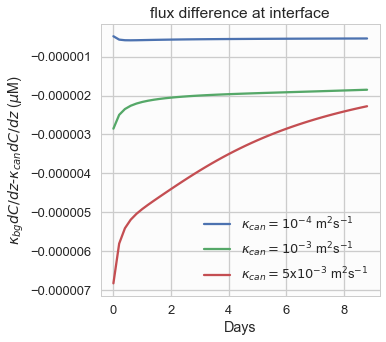

In [70]:
sns.set_style('whitegrid',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot concentration contours
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey = False)

CS = ax.plot(np.array(times)*to_day,
            ((kappa_bg*(conc_2D_sm[int(nz/2)-2,:] - 2*conc_2D_sm[int(nz/2)-1,:]+conc_2D_sm[int(nz/2),:])/(2*dz)))-
            (1E-4*(conc_2D_sm[int(nz/2)+2,:] - 2*conc_2D_sm[int(nz/2)+1,:]+conc_2D_sm[int(nz/2),:])/(2*dz)),
            label='$\kappa_{can}=10^{-4}$ m$^2$s$^{-1}$')

CS = ax.plot(np.array(times)*to_day,
            ((kappa_bg*(conc_2D[int(nz/2)-2,:] - 2*conc_2D[int(nz/2)-1,:]+conc_2D[int(nz/2),:])/(2*dz)))-
            (kappa_can*(conc_2D[int(nz/2)+2,:] - 2*conc_2D[int(nz/2)+1,:]+conc_2D[int(nz/2),:])/(2*dz)),
            label='$\kappa_{can}=10^{-3}$ m$^2$s$^{-1}$')

CS = ax.plot(np.array(times)*to_day,
            ((kappa_bg*(conc_2D_bg[int(nz/2)-2,:] - 2*conc_2D_bg[int(nz/2)-1,:]+conc_2D_bg[int(nz/2),:])/(2*dz)))-
            (5E-3*(conc_2D_bg[int(nz/2)+2,:] - 2*conc_2D_bg[int(nz/2)+1,:]+conc_2D_bg[int(nz/2),:])/(2*dz)),
            label='$\kappa_{can}=5$x$10^{-3}$ m$^2$s$^{-1}$')

ax.legend(loc=0)
ax.set_ylabel('$\kappa_{bg}dC/dz$-$\kappa_{can}dC/dz$ ($\mu$M)')
ax.set_xlabel('Days')
ax.set_title('flux difference at interface')



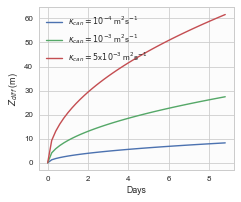

In [71]:
sns.set_style('whitegrid',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})
sns.set_context('paper')
# Plot concentration contours
fig, ax = plt.subplots(1,1, figsize=(3.5,3), sharey = False)

for kcan, lab in zip([1E-4, 1E-3, 5E-3],['10^{-4}','10^{-3}','5$x$10^{-3}']):
    
    Z_diff = np.sqrt((kcan-kappa_bg)*np.array(times)*60) # * 60 seconds

    CS = ax.plot(np.array(times)*to_day,Z_diff,
                label=(r'$\kappa_{can}=%s$ m$^2$s$^{-1}$' %lab))


ax.legend(loc=0)
ax.set_ylabel('$Z_{diff}$ (m)')
ax.set_xlabel('Days')
plt.savefig('Z_diff.eps',format='eps',bbox_inches='tight')


## Figure for paper

4.0
14.0
24.0
34.0
44.0


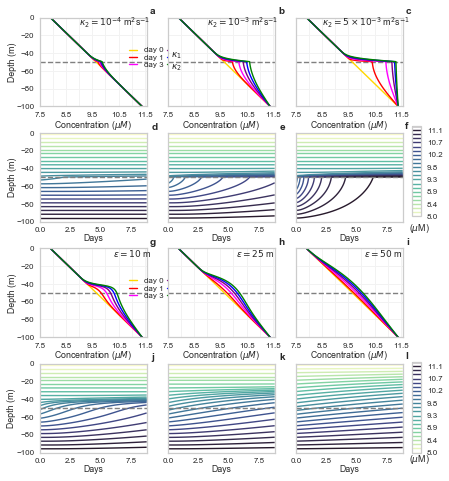

In [72]:
sns.set_style('white',{"axes.edgecolor": ".8", "axes.facecolor": "1"})
sns.set_context('paper')
plt.rcParams['font.size'] = 9.0
colors=[ 'red','magenta','purple','blue','green']
# Plot density contours
fig,ax = plt.subplots(4,3,figsize = (6.5,8), sharey=True) # 190mm = 7.48 in, 230cm = 9.05in
fig.subplots_adjust(hspace=0.3, wspace=0.2)

for ii in range(4):
    for jj in range(3):
        ax[ii,jj].axhline(-int(nz/2), linestyle='--', color='0.5')
    
# KV'S
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

for ii in range(3):
    l1 = plotCpaper(ax[0,ii], IC, L, nz, 'gold')
    ax[0,ii].grid(color='0.95', linestyle='-', linewidth=1)
    ax[2,ii].grid(color='0.95', linestyle='-', linewidth=1)


lines = [l1]

for time, col in zip(times[4::10], colors):
    l2 = plotCpaper(ax[0,0], conc_2D_sm[:,int(time/288)], L, nz, col)
    lines.append(l2)
    print(((time)/288)) 
    l2 = plotCpaper(ax[0,1], conc_2D[:,int(time/288)], L, nz, col)
    l2 = plotCpaper(ax[0,2], conc_2D_bg[:,int(time/288)], L, nz, col)

ax[0,0].text(11.7,4,'a',weight='semibold', fontsize=10)
ax[0,1].text(11.7,4,'b',weight='semibold', fontsize=10)
ax[0,2].text(11.7,4,'c',weight='semibold', fontsize=10)

ax[1,0].text(9.2,4,'d',weight='semibold', fontsize=10)
ax[1,1].text(9.2,4,'e',weight='semibold', fontsize=10)
ax[1,2].text(9.0,5,'f',weight='semibold', fontsize=10)

ax[2,0].text(11.7,4,'g',weight='semibold', fontsize=10)
ax[2,1].text(11.7,4,'h',weight='semibold', fontsize=10)
ax[2,2].text(11.7,4,'i',weight='semibold', fontsize=10)

ax[3,0].text(9.2,4,'j',weight='semibold', fontsize=10)
ax[3,1].text(9.2,4,'k',weight='semibold', fontsize=10)
ax[3,2].text(9.0,5,'l',weight='semibold', fontsize=10)

ax[0,0].legend((lines), ('day 0' , 'day %1.0f' %(times[4]*to_day+0.2),
                                     'day %1.0f' %(times[14]*to_day+0.2),
                                     'day %1.0f' %(times[24]*to_day+0.2),
                                     'day %1.0f'%(times[34]*to_day+0.2),
                                     'day %1.0f'%(times[44]*to_day+0.2)),
               ncol=2,columnspacing=0.5,labelspacing=0.1,bbox_to_anchor=(0.77,0.35),handlelength=1)
ax[0,1].set_ylabel('')
ax[0,2].set_ylabel('')

ax[0,0].text(9.0, -10, r'$\kappa_{2} = 10^{-4}$ m$^2$s$^{-1}$')
ax[0,1].text(9.0, -10,r'$\kappa_{2} = 10^{-3}$ m$^2$s$^{-1}$')
ax[0,2].text(8.5, -10,r'$\kappa_{2} = 5 \times 10^{-3}$ m$^2$s$^{-1}$')

ax[0,0].set_xticks([7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5])
ax[0,0].set_xticklabels(['7.5','','8.5','','9.5','','10.5','','11.5'])
ax[0,1].set_xticks([7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5])
ax[0,1].set_xticklabels(['7.5','','8.5','','9.5','','10.5','','11.5'])
ax[0,2].set_xticks([7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5])
ax[0,2].set_xticklabels(['7.5','','8.5','','9.5','','10.5','','11.5'])

# CONTOURS KV'S

CS = ax[1,0].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_sm,25, cmap=cmo.cm.deep)
ax[1,0].set_xlabel('Days',labelpad=0.8)
ax[1,0].set_ylabel('Depth (m)',labelpad=-0.5)

CS = ax[1,1].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D,25, cmap=cmo.cm.deep)
ax[1,1].set_xlabel('Days',labelpad=0.8)

CS = ax[1,2].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_bg,25, cmap=cmo.cm.deep)

cb = fig.add_axes([0.92, 0.535, 0.02, 0.157])  
CB = plt.colorbar(CS, cax=cb, format='%1.1f')
ax[1,2].text(9.3,-110,'($\mu$M)')
ax[1,2].set_xlabel('Days',labelpad=0.8)

# EPSILONS
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

for ii in range(3):
    l1 = plotCpaper(ax[2,ii], IC, L, nz, 'gold')
   
lines = [l1]

for time,col in zip(times[4::10], colors):
    l2 = plotCpaper(ax[2,0], conc_2D_e10[:,int(time/288)], L, nz, col)
    lines.append(l2)
    l2 = plotCpaper(ax[2,1], conc_2D_e25[:,int(time/288)], L, nz,col)
    l2 = plotCpaper(ax[2,2], conc_2D_e50[:,int(time/288)], L, nz, col)

ax[2,0].legend((lines), ('day 0' , 'day %1.0f' %(times[4]*to_day+0.2),
                        'day %1.0f' %(times[14]*to_day+0.2),
                        'day %1.0f' %(times[24]*to_day+0.2),
                        'day %1.0f'%(times[34]*to_day+0.2),
                        'day %1.0f'%(times[44]*to_day+0.2)),
               ncol=2,columnspacing=0.5,labelspacing=0.1,bbox_to_anchor=(0.77,0.35),handlelength=1) 
ax[2,1].set_ylabel('')
ax[2,2].set_ylabel('')

ax[2,0].text(10.3, -10, r'$\epsilon = 10$ m')
ax[2,1].text(10.1, -10,r'$\epsilon = 25$ m')
ax[0,1].text(7.6,-45, r'$\kappa_1$')
ax[0,1].text(7.6,-58, r'$\kappa_2$')

ax[2,2].text(10.1, -10,r'$\epsilon = 50$ m')

ax[2,0].set_xticks([7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5])
ax[2,0].set_xticklabels(['7.5','','8.5','','9.5','','10.5','','11.5'])
ax[2,1].set_xticks([7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5])
ax[2,1].set_xticklabels(['7.5','','8.5','','9.5','','10.5','','11.5'])
ax[2,2].set_xticks([7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5])
ax[2,2].set_xticklabels(['7.5','','8.5','','9.5','','10.5','','11.5'])

# EPSILONS

CS = ax[3,0].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_e10,25, cmap=cmo.cm.deep)
ax[3,0].set_xlabel('Days', labelpad=0.6)
ax[3,0].set_ylabel('Depth (m)',labelpad=0.1 )
CS = ax[3,1].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_e25,25, cmap=cmo.cm.deep)
ax[3,1].set_xlabel('Days', labelpad=0.6)

CS = ax[3,2].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_e50,25, cmap=cmo.cm.deep)

cb = fig.add_axes([0.92, 0.125, 0.02, 0.157]) 
CB = plt.colorbar(CS, cax=cb, format='%1.1f')
ax[3,2].text(9.3,-110,'($\mu$M)')
ax[3,2].set_xlabel('Days',labelpad=0.6)



#plt.tight_layout()

plt.savefig('figureB1.eps',format='eps',bbox_inches='tight')
